In [43]:
# This is just for the 3D plot later.
!pip install plotly

In [44]:
# The most important package in python for linear algebra is numpy
# sklearn has a lot of ML tools
# pandas dataframe object is a good way to start thinking about ML
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sn
import plotly.express as px

This is a dataset of 70,000 28x28 images, each flattened into a row. To make the flattened rows, each of the images is split into rows. Then the image rows are stacked horizontally. Thus, each column represents a specific pixel location of the original image.

$$I=
\overbrace{\begin{bmatrix}
0 & 0 & 0 & \cdots & 0 & 0 & 0 \\
\vdots & & & & & & \vdots \\
0 & 0 & 0 & \cdots & 0 & 0 & 0
\end{bmatrix}}^{28 px}
\to \left.
\begin{bmatrix}
0 & 0 & 0 & \cdots & 0 & 0 & 0 \\ \hline
\vdots & & & & & & \vdots \\ \hline
0 & 0 & 0 & \cdots & 0 & 0 & 0
\end{bmatrix}
\right\}28 px \to
\overbrace{\begin{bmatrix}
0 & 0 & 0 & \cdots & 0 & 0 & 0 & | & 0 & 0 & 0 & \cdots & 0 & 0 & 0 & | & \cdots
\end{bmatrix}}^{28^2 px}$$



In [45]:
# This may take a while.
# Don't try to run this on wifi with everyone else, just follow along.

mnist_data = datasets.fetch_openml('mnist_784', version=1)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Whenever doing machine learning or data processing, it's important to understand what the data looks like. In this case, the data comes in the form of vectors/matrices that are sparse (a lot of their entries are 0). This should be an immediate clue that the data is lower dimensional than it appears. This data is also completely integer data, even though it is stored as floats. It may then be a useful preprocessing step to convert to ints.

In [46]:
i = 1
print("Instance of data labeled '{}':\n".format(mnist_data.target[i]))
datumi = np.reshape(mnist_data.data.values[i, :], (28, 28))
for row in datumi:
    print('|', end='   ')
    for pixel in row:
        intensity = np.int64(pixel)
        print( intensity, end='{}'.format(' ' * (4 - len(str(intensity)))) )
    print('|')

Instance of data labeled '0':

|   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   |
|   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   |
|   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   |
|   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   |
|   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   51  159 253 159 50  0   0   0   0   0   0   0   0   |
|   0   0   0   0   0   0   0   0   0   0   0   0   0   0   48  238 252 252 252 237 0   0   0   0   0   0   0   0   |
|   0   0   0   0   0   0   0   0   0   0   0   0   0   54  227 253 252 239 233 252 57  6   0   0   0   0   0   0   |
|   0   0   0   0   0   0   0   0   0   0   0   10  60  224 252 253 252 202 84  252 253 122 0   0   0   0   0   0   |
|   0   0   0   0   0   0

In [47]:
def extract_image(data, i, dim=-1):
    extracted = []
    for j in i:
        extracted.append(np.reshape(data[j, :], dim))

    return extracted

def show_images(data, show):
    images = extract_image(data, show, (28, 28))
    fig, axes = plt.subplots(1, len(show), figsize=(200/len(show), 10))
    for i, ax in enumerate(axes):
        ax.matshow(-images[i], cmap=plt.cm.gray)
        ax.set_xticks(())
        ax.set_yticks(())

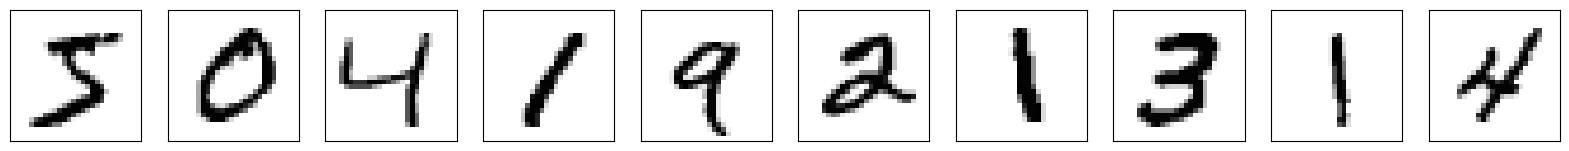

In [48]:
show_images(mnist_data.data.values, range(10))

Principal Componenent Analysis, also called the Proper Orthogonal Decomposition and many other names, is a statistical technique which performs a coordinate shift. In particular, the coordinates it chooses are those which capture the most variance (think linear regression), and are mutually orthogonal. The most important thing to notice is that we don't give the PCA the labels.

In practice, a highly efficient LAPACK routine can be used to compute the PCA since it is closely related to the SVD, a matrix decomposition technique. ![A diagram illustrating the SVD matrix decomposition.](https://staging.njtrainingacademy.com/wp-content/uploads/2019/01/svd_heading_img.png)

In [49]:
def pca(data, plot_variance=True, variance_captured=np.array([.90, .95, .99])):
    # The principal component analysis requires that data is demeaned and normalized
    data = data.values

    mean = data.mean(axis=1)
    std = np.std(data, axis=1)
    data = (data - mean[:, np.newaxis])/std[:, np.newaxis]

    # This is the singular value decomposition, which gives the singular values s
    u, s, v = np.linalg.svd(data, full_matrices=False)
    if plot_variance:
        fig, axes = plt.subplots(1, 2, figsize=(20, 10))
        axes[0].plot(s, linestyle=':')

        # The variance is s^2, so we can see how much variance is captured with each dimension
        energy = np.power(s, 2)
        energy = energy / np.sum(energy)
        energy_up_to = np.cumsum(energy)
        axes[1].plot(energy_up_to)

        axes[1].hlines(variance_captured, 0, len(energy_up_to), linestyles='dashed')
        dims = np.tile(energy_up_to, (len(variance_captured), 1))>np.tile(variance_captured, (len(energy_up_to), 1)).T
        dims = np.argmax(dims, axis=1)

        print('Dimensions to capture:\n')
        for i, j in zip(variance_captured, dims):
          print(f'{i*100:.2f}% variance: {j}')

        print(f'100.0% variance: {data.shape[1]} (Complete Data)')

        axes[1].scatter(dims, variance_captured, marker='s', s=75, c='red')

    # This computes the principle components.
    # Alternatively, this can be computed as X*V if V is full.
    return u @ np.diag(s), [u,s,v], dims, mean, std

Dimensions to capture:

90.00% variance: 67
95.00% variance: 123
99.00% variance: 298
99.90% variance: 467
99.99% variance: 569
100.0% variance: 784 (Complete Data)


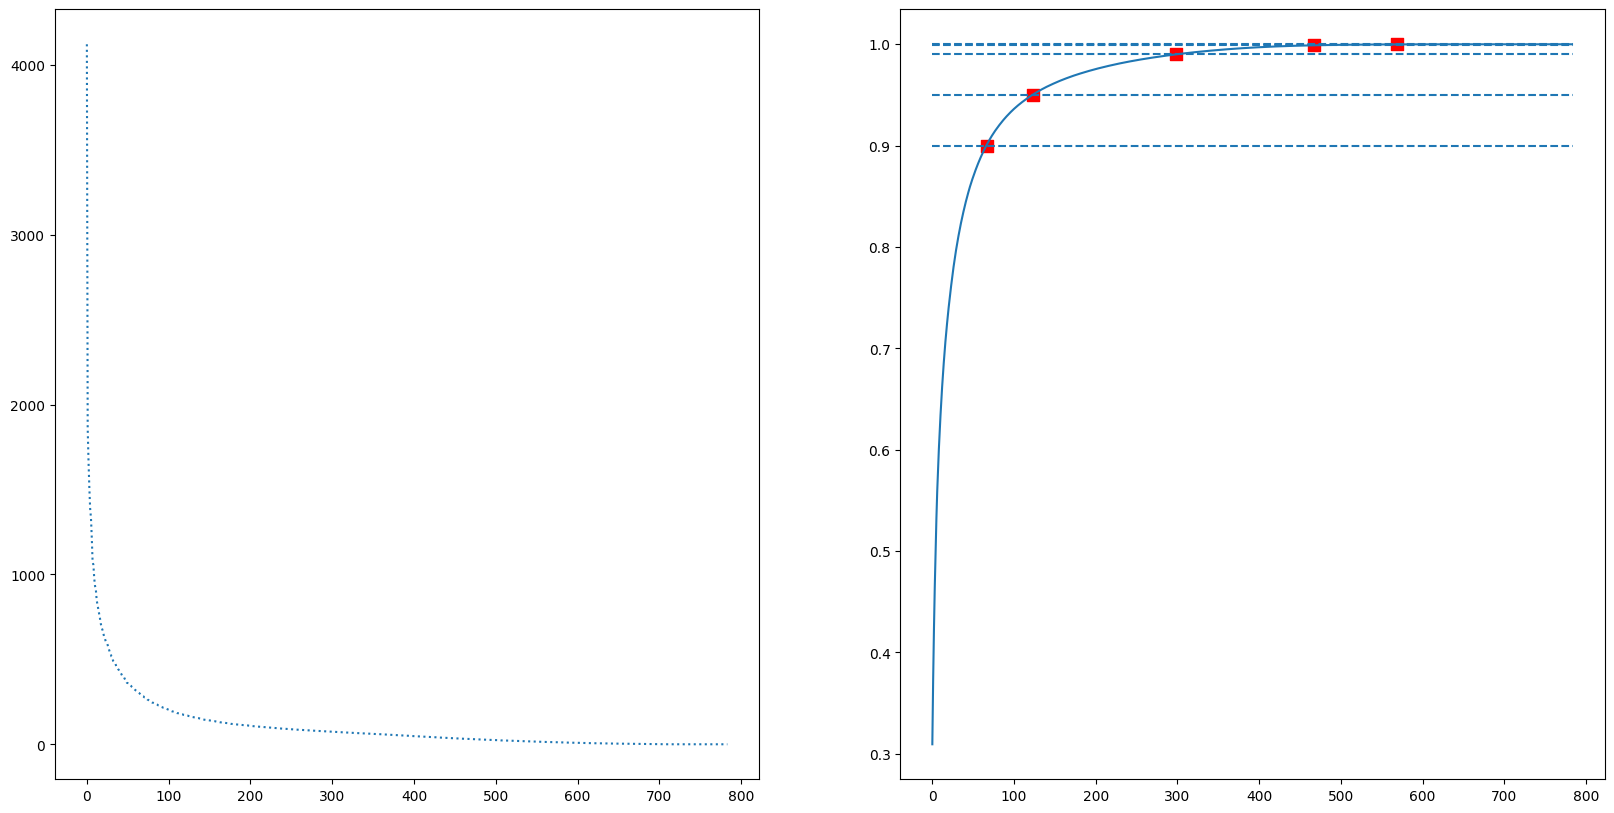

In [50]:
PC, svd, dims, mu, sd = pca(mnist_data.data, variance_captured=np.array([.90, .95, .99, .999, .9999])) # compression to 8.5% (67/784) while losing only 10% information (90% variance still present)

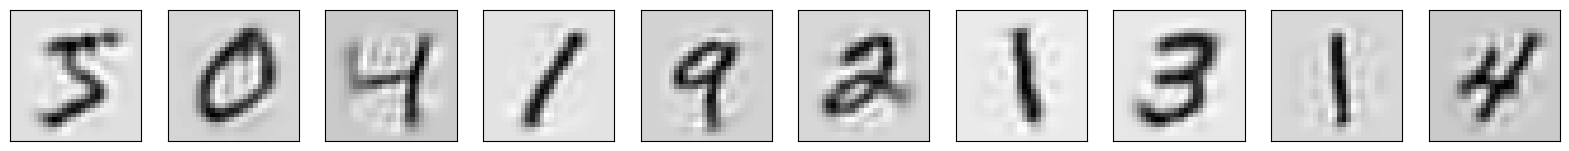

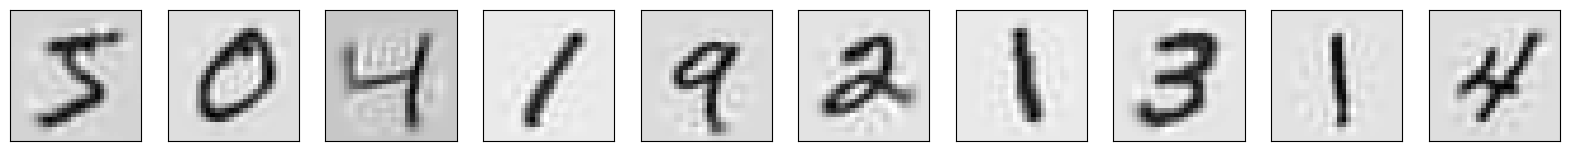

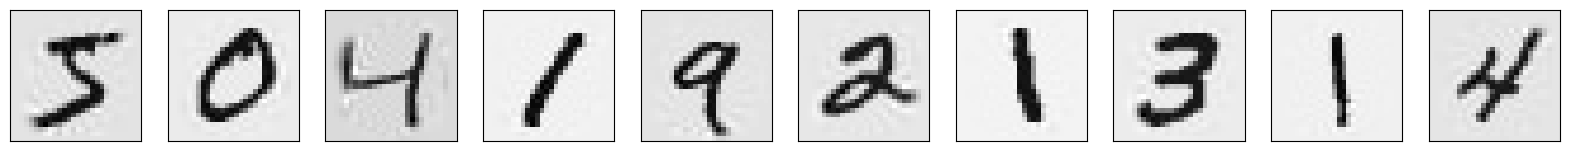

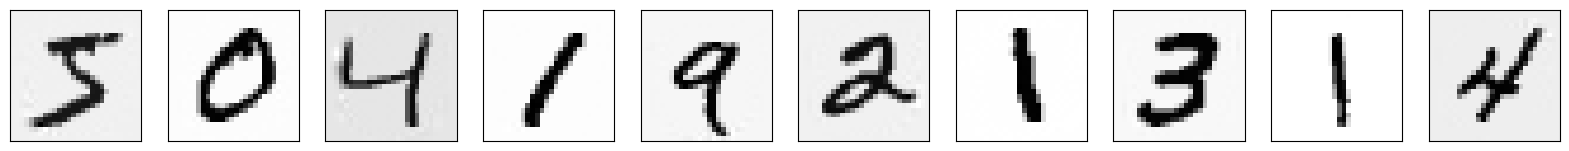

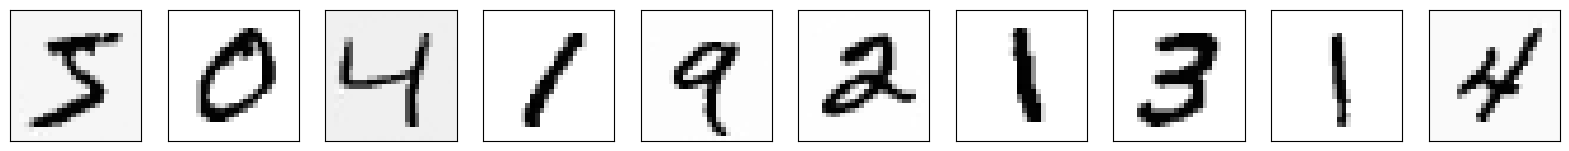

In [51]:
def compress(data, SVD, r, m, std):
    u, s, v = SVD

    for trunc in r:
        s_r = np.copy(s)
        s_r[(trunc+1):] = 0

        #print(std.shape, u.shape, s_r.shape, v.shape, m.reshape(-1, 1).shape, (std.reshape(-1, 1) * (u * s_r) @ v).shape)

        X_r = std.reshape(-1, 1) * (u * s_r) @ v + m.reshape(-1, 1)

        show_images(X_r, range(10))

compress(mnist_data.data, svd, dims, mu, sd)

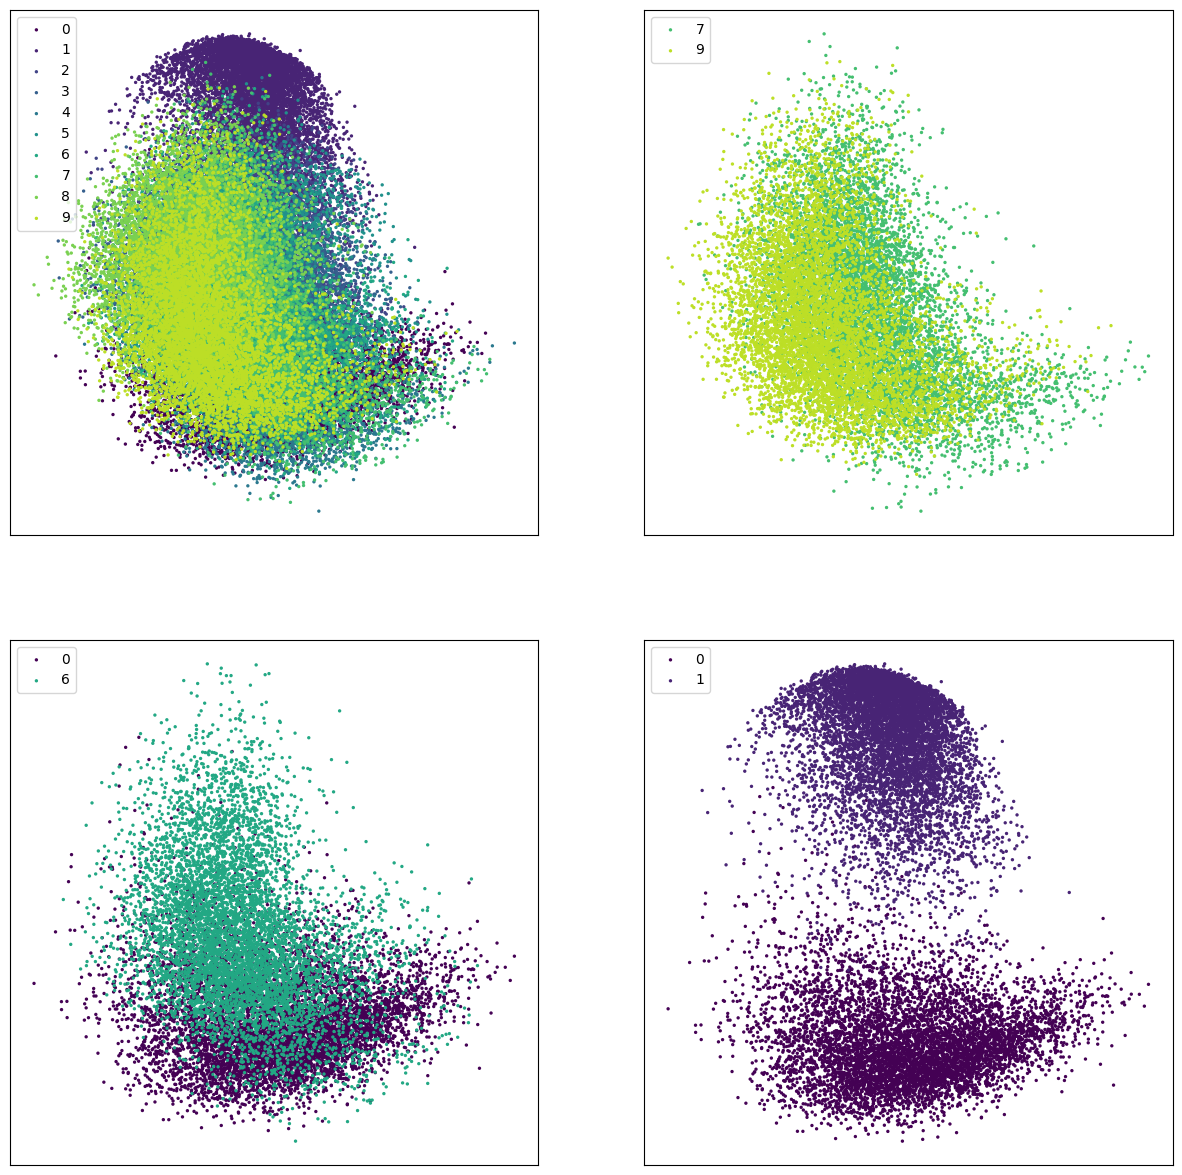

In [52]:
def plot_class_pca(pca, target, class_list, figure, axis, dim=2):
    #target = target.values

    viridis = plt.get_cmap('viridis')
    plotted = np.zeros_like(target).astype(bool)
    if dim==2:
        for i in class_list:
            kind = target == i
            axis.scatter(pca[kind, 0], pca[kind, 1], s=2, alpha=.99, c=viridis(i*np.ones_like(pca[kind, 0])/10), label=str(i))
            plotted = kind | plotted

        axis.legend(loc='upper left')
        axis.set_xticks(())
        axis.set_yticks(())

        return pca[plotted, 0:dim], target[plotted], plotted

    elif dim==3:
        pca = pca.loc[np.in1d(pca['target'].to_numpy(), class_list), :]

        fig = px.scatter_3d(pca, x='PC1', y='PC2', z='PC3', color='target', size_max=10)
        fig.show()

        return pca

    else:
        print('dim should be 2 or 3')



fig, axes = plt.subplots(2, 2, figsize=(15, 15))
target = mnist_data.target.astype(np.int64)

plot_class_pca(PC, target, np.arange(10), fig, axes[0][0])
plot_class_pca(PC, target, np.array([0,6]), fig, axes[1][0])
plot_class_pca(PC, target, np.array([7,9]), fig, axes[0][1])
pc01, labels, which_plotted = plot_class_pca(PC, target, np.array([0, 1]), fig, axes[1][1])

In [53]:
df_PC = pd.DataFrame(np.hstack([PC[:, 0:3], target.values.reshape(-1, 1)]), columns=['PC1', 'PC2', 'PC3', 'target'])
df_PC['target'] = df_PC['target'].astype(np.int64).astype(str)
df_PC_pltd = plot_class_pca(df_PC, target, np.array(['0', '1', '7']), None, None, dim=3)
df_PC_pltd.head(10)

,PC1,PC2,PC3,target
1,-14.941680,-6.703878,9.496803,0
3,-13.737821,13.534427,2.814444,1
6,-15.744783,7.955853,-2.520242,1
8,-13.433304,9.720443,-4.323656,1
14,-13.423707,11.514742,-1.832629,1
15,-16.407798,-3.332879,-10.726163,7
21,-14.981036,-5.085182,8.965313,0
23,-13.907220,12.941157,1.836806,1
24,-15.723184,4.413958,2.049199,1
29,-14.413398,4.956073,-4.807225,7


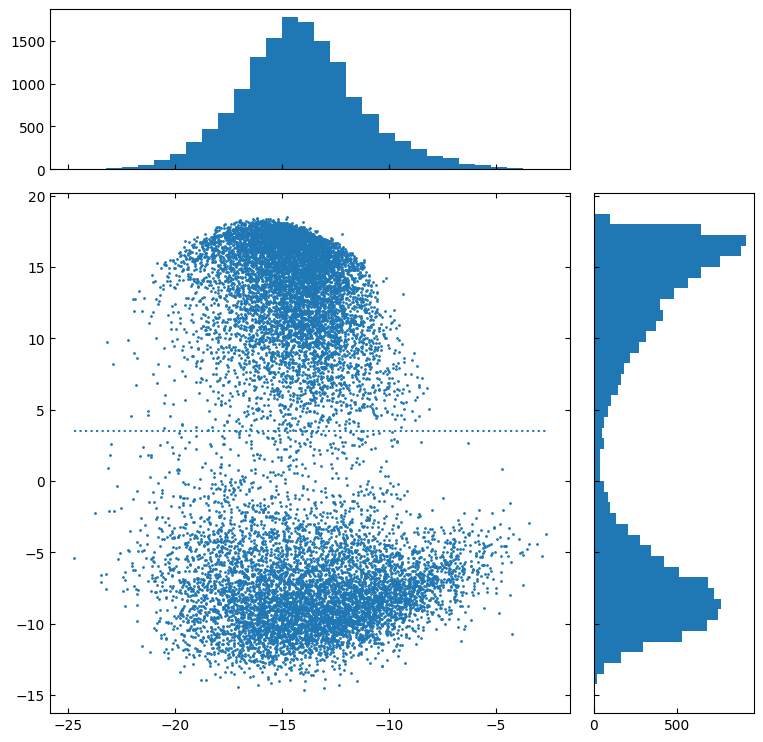

In [54]:
x = pc01[:,0]
y = pc01[:,1]

left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.03

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(figsize=(8, 8))

ax_scatter = plt.axes(rect_scatter)
ax_scatter.tick_params(direction='in', top=True, right=True)
ax_histx = plt.axes(rect_histx)
ax_histx.tick_params(direction='in', labelbottom=False)
ax_histy = plt.axes(rect_histy)
ax_histy.tick_params(direction='in', labelleft=False)

ax_scatter.scatter(x, y, s=1)
ax_scatter.hlines(np.mean(pc01[:,1]), min(pc01[:,0]), max(pc01[:,0]), linestyles='dotted')

binwidth = 0.75
lim = np.ceil(np.abs([x, y]).max() / binwidth) * binwidth

bins = np.arange(-lim, lim + binwidth, binwidth)
ax_histx.hist(x, bins=bins)
ax_histy.hist(y, bins=bins, orientation='horizontal')

ax_histx.set_xlim(ax_scatter.get_xlim())
ax_histy.set_ylim(ax_scatter.get_ylim())

# Ones are on top, zeros on the bottom
# Let's do a simple mean discriminator along the axis of separation
predicted_1 = pc01[:,1] - np.mean(pc01[:,1]) > 0 # predicts this data to represent 1
predicted_0 = pc01[:,1] - np.mean(pc01[:,1]) <= 0 # predicts this data to represent 0

Text(0.5, 14.049999999999999, 'Actual Class')

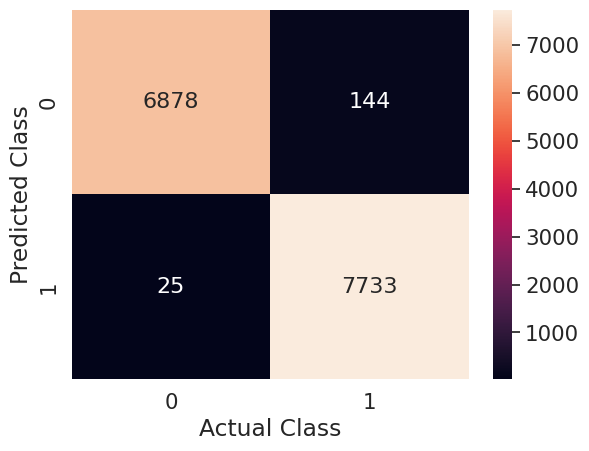

In [55]:
p0a0 = np.sum(labels[predicted_0]==0) # predicted 0 actually 0 ...
p0a1 = np.sum(labels[predicted_0]==1)
p1a0 = np.sum(labels[predicted_1]==0)
p1a1 = np.sum(labels[predicted_1]==1)

confusion = np.array([[p0a0, p0a1], [p1a0, p1a1]])
df_cm = pd.DataFrame(confusion, [0, 1], [0, 1])

sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, fmt='d', annot_kws={"size": 16})
plt.ylabel("Predicted Class")
plt.xlabel("Actual Class")

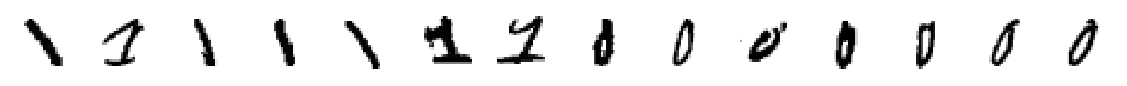

In [56]:
predicted_0_label = np.where(predicted_0,0,np.nan)
predicted_1_label = np.where(predicted_1,1,np.nan)

j1 = np.where(1-predicted_0_label==labels)
j2 = np.where(1-predicted_1_label==labels)

misclassified = [*j1[0][0:7], *j2[0][0:7]]

show_images(mnist_data.data.loc[which_plotted, :].values, misclassified)